In [23]:
from transformers import BertTokenizer, BertModel
from transformers import DistilBertModel, DistilBertTokenizer
import pyarrow.dataset as ds
import datasets
from datasets import concatenate_datasets, load_dataset, Dataset
import ast # used to get dict out of str representatation of dict
import pandas as pd
import seaborn as sns
import torch
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [ ]:
# # load a small part of the dataset in an iterable form 
# iterable_ds = load_dataset("wmt14", "fr-en", split="train", streaming=True, trust_remote_code=True)
# iterable_ds = iterable_ds.take(5000)

# # convert from iterable dataset to arrow dataset
# def gen_from_iterable_dataset(iterable_ds):
#     yield from iterable_ds

# ds = Dataset.from_generator(partial(gen_from_iterable_dataset, iterable_ds), features=iterable_ds.features)

## 1) Tokenization: Using the Sequoia and the German GSD corpora:

In [24]:
sequoia = datasets.load_dataset("universal_dependencies", "fr_sequoia")
fr_df = concatenate_datasets([sequoia.get("train"), sequoia.get("validation"), sequoia.get("test")]) 

gsd = datasets.load_dataset("universal_dependencies", "de_gsd")
de_df = concatenate_datasets([gsd.get("train"), gsd.get("validation"), gsd.get("test")]) 

Sequoia Dataset 

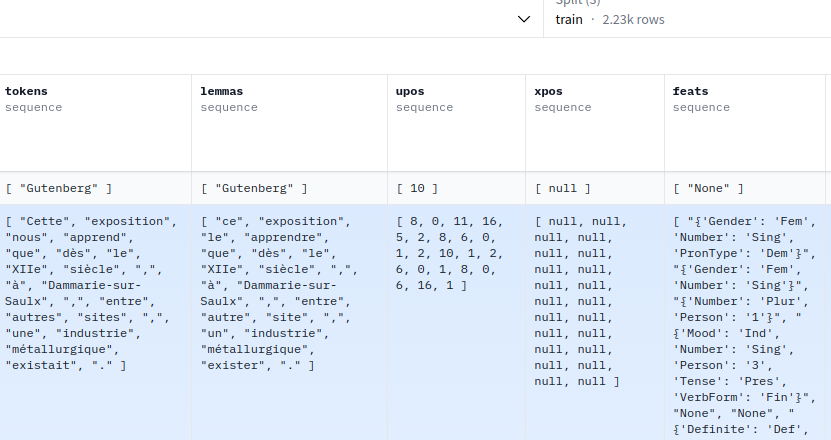

### • extract all nouns and their gender (include epicene nouns for french)

In [25]:
def get_noun_gender_df(arrow_df): # see format arrow_df: https://huggingface.co/datasets/universal_dependencies/viewer/de_gsd?row=0
    
    df = pd.DataFrame(arrow_df) 
    d = df[["tokens", "upos", "feats"]].explode(column=["tokens", "upos","feats"])
    d["feats"] = d["feats"].apply(lambda x: eval(x).get("Gender") if eval(x) is not None else None)
    d = d[d["upos"] == 0].drop('upos', axis=1) # after extracting nouns from the df (0 stands for noun), remove upos column
    d = d.drop_duplicates() # remove rows that are exactly the same (exept for the first duplicate found)
    
    return d[d["feats"].notna()] # return rows without feats = None

fr_df = get_noun_gender_df(fr_df)
de_df = get_noun_gender_df(de_df)

print("building pandas df result is:\n\n", fr_df)

building pandas df result is:

             tokens feats
1       exposition   Fem
1           siècle  Masc
1            sites  Masc
1        industrie   Fem
2            forge   Fem
...            ...   ...
3092   spéculation   Fem
3092    domination   Fem
3093  colonisation   Fem
3097      Colloque  Masc
3097       fraudes   Fem

[3673 rows x 2 columns]


In [26]:
def get_epicene(pd_df):
    return pd_df[pd_df.duplicated(subset=['tokens'], keep=False)].sort_values(by=['tokens']) # return rows that have the same token
    
epicene_df = get_epicene(fr_df)
print(f"{epicene_df}\n\nnumber epicene nouns {len(epicene_df) // 2}")

              tokens feats
1134     Commissaire  Masc
1206     Commissaire   Fem
2180         Edition   Fem
1726         Edition  Masc
398              ICP   Fem
414              ICP  Masc
503   brachythérapie  Masc
504   brachythérapie   Fem
786          docteur  Masc
1167         docteur   Fem
1742            juge   Fem
1667            juge  Masc
1738           morts   Fem
1532           morts  Masc
1851      politiques  Masc
1450      politiques   Fem
2123      secrétaire   Fem
207       secrétaire  Masc
1521        Éditions   Fem
1522        Éditions  Masc

number epicene nouns 10


There are only 10 epicenes nouns in the whole dataset, so epicene nouns will not have an impact on the distribution of subtokens.

### • tokenize the noun using the mBERT tokenizer;

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def get_len_subtoken(text):
    # [1:-1], leave out [CLS] and [SEP] since they are not informative for this exercice
    return len( tokenizer(text)['input_ids'][1:-1] ) 

fr_df['tokens'] = fr_df['tokens'].apply(get_len_subtoken)
de_df['tokens'] = de_df['tokens'].apply(get_len_subtoken)

print("tokenizing and getting lenght of subtokens:\n\n", fr_df.rename(columns={"tokens": "nb_subtokens"}))

tokenizing and getting lenght of subtokens:

       nb_subtokens feats
1                1   Fem
1                1  Masc
1                1  Masc
1                1   Fem
2                2   Fem
...            ...   ...
3092             3   Fem
3092             1   Fem
3093             3   Fem
3097             3  Masc
3097             2   Fem

[3673 rows x 2 columns]


### • for each grammatical gender, determine the distribution of the number of subtokens resulting from the tokenization of a noun;

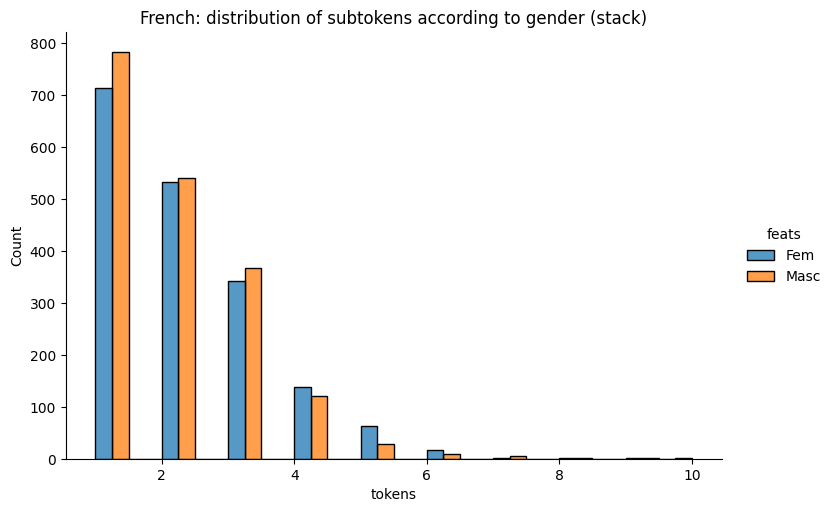

In [28]:
sns.displot(data=fr_df, x="tokens", hue="feats", binwidth=0.5, height=5, aspect=1.5, multiple="dodge").set(title='French: distribution of subtokens according to gender (stack)');

For French, there are more masculine nouns tokenized into 1-3 subtokens. 

There are more feminine nouns tokenized into 4 subtokens onwards.

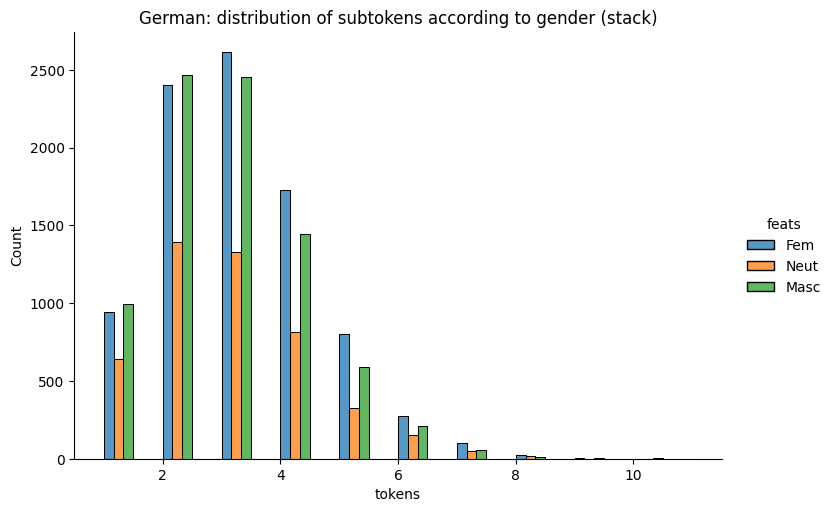

In [29]:
sns.displot(data=de_df, x="tokens", hue="feats", binwidth=0.5, height=5, aspect=1.5, multiple="dodge").set(title='German: distribution of subtokens according to gender (stack)');

The distribution of masculine and feminine nouns is similar to French. With lower numbers of subtokens, masculine nouns are in the majority, but afterwards, they are more feminine nouns.

Neutral nouns are always tokenized into a smaller amount of subtokens compared to masculine and feminine nouns.

### • what can you conclude

Overall, mBert tokenizes feminine nouns into more subtokens than masculine nouns.

## 2) Using BERT features

### • get the embeddings of the amazon_polarity dataset

In [9]:
# dataset: arrow_dataset (from HuggingFace)
train_dataset = load_dataset("amazon_polarity", split="train[:80000]")
test_dataset = load_dataset("amazon_polarity", split="test[:8000]")

    dbert = DistilBertModel.from_pretrained("distilbert-base-uncased").to("cuda")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Amazon Polarity Dataset: 

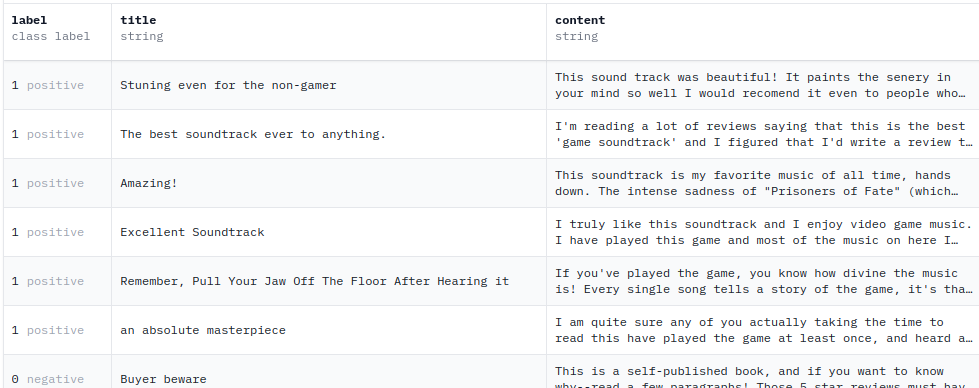

In [10]:
def get_embedding(batch):

    # title_input has both input_ids(tokenization ids) and attention mask to, among other things, ignore padding
    # to("cuda"): use gpu instead of cpu for faster computation
    title_input = tokenizer(batch["title"], return_tensors='pt', padding=True).to("cuda")

    with torch.no_grad():
        output = dbert(**title_input)
    
    cls_token_encoding = output["last_hidden_state"][:,0,:]
    mean_pooling_encoding = torch.mean(output["last_hidden_state"], dim=1)
    
    return {"cls_token_encoding": cls_token_encoding, "mean_pooling_encoding": mean_pooling_encoding}

train_df = train_dataset.map(get_embedding, remove_columns=["title", "content"], batched=True, batch_size=100)
test_df = test_dataset.map(get_embedding, remove_columns=["title", "content"], batched=True, batch_size=100)

### • use the representations to train a logistic regression model: <br> compare two strategies for getting the representation of a sentence: use either the [CLS] token or the mean of all token representations (mean-pooling)

In [ ]:
classifier_cls = LogisticRegression(solver="liblinear", penalty="l1");
classifier_mean = LogisticRegression(solver="liblinear", penalty="l1");

X_train_cls = train_df["cls_token_encoding"]
X_train_mean = train_df["mean_pooling_encoding"]
Y_train = train_df["label"]

X_test_cls = test_df["cls_token_encoding"]
X_test_mean = test_df["mean_pooling_encoding"]
Y_test = test_df["label"]

classifier_cls.fit(X_train_cls, Y_train);
classifier_mean.fit(X_train_mean, Y_train);

### • compare the performance to the one you have achieved in the first lab and test for different training set size

In [ ]:
print(f"for {len(train_dataset)} examples:")

# accuracy
print(f"Accuracy of classifier_cls on train set: {classifier_cls.score(X_train_cls, Y_train)}")
print(f"Accuracy of classifier_cls on test set: {classifier_cls.score(X_test_cls, Y_test)}")

print(f"Accuracy of classifier_mean on train set: {classifier_mean.score(X_train_mean, Y_train)}")
print(f"Accuracy of classifier_mean on test set: {classifier_mean.score(X_test_mean, Y_test)}")

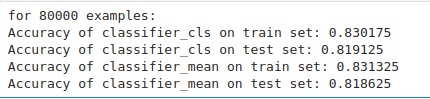

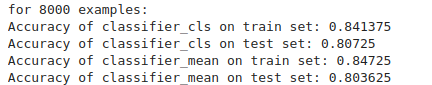

Accuracy of TP1

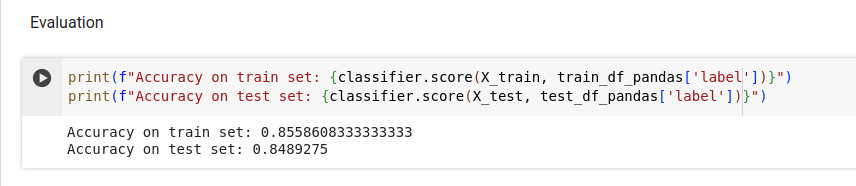

The accuracy is slightly higher when I take the cls representation of a sentence, but they are very close to eachother

The accuracy goes up according to the amount of training data. With 8000 examples for training, the accuracy is around 80% and it almost reaches 82% when there are 80 000 examples for training. I tried with a bigger training dataset but, because of RAM issues, the program is killed.

The accuracy in the current tp is similar compared to the one in TP1 